In [849]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import seaborn as sns
import os
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from scipy import stats
from sklearn.metrics import mean_squared_error, r2_score


## Dataset Exploration

In [850]:
# Retrieve path and load the data
path = os.getcwd()
df = pd.read_csv(path+"/train.csv")
df_test = pd.read_csv(path+"/test.csv")
df_test.head()

,id,num_rooms,num_baths,square_meters,orientation,year_built,door,is_furnished,has_pool,neighborhood,num_crimes,has_ac,accepts_pets,num_supermarkets
0,6253,NaN,1.0,152.0,NaN,2012.0,5º - 4a,True,True,Les Cors,0.0,False,False,NaN
1,4685,NaN,2.0,90.0,east,1957.0,10º - 1a,True,False,Ciutat Vella,2.0,False,True,3.0
2,1732,NaN,2.0,86.0,NaN,1991.0,5º - 2a,False,False,Eixample,0.0,False,True,NaN
3,4743,NaN,3.0,164.0,NaN,2002.0,8º - 4a,False,True,Nou Barris,7.0,False,False,NaN
4,4522,NaN,1.0,99.0,NaN,1984.0,8º - 4a,True,True,Sant Andreu,0.0,True,False,3.0


In [851]:
# Types of the variables and number of non NaN
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                8000 non-null   int64  
 1   num_rooms         8000 non-null   float64
 2   num_baths         7840 non-null   float64
 3   square_meters     7845 non-null   float64
 4   orientation       5659 non-null   object 
 5   year_built        7830 non-null   float64
 6   door              7851 non-null   object 
 7   is_furnished      7835 non-null   object 
 8   has_pool          7844 non-null   object 
 9   neighborhood      7835 non-null   object 
 10  num_crimes        7840 non-null   float64
 11  has_ac            7831 non-null   object 
 12  accepts_pets      7845 non-null   object 
 13  num_supermarkets  1411 non-null   float64
 14  price             8000 non-null   int64  
dtypes: float64(6), int64(2), object(7)
memory usage: 937.6+ KB


In [852]:
# Number of rows and columns
df.shape

(8000, 15)

In [853]:
# Descriptive statistics of the data
df.describe()

,id,num_rooms,num_baths,square_meters,year_built,num_crimes,num_supermarkets,price
count,8000.000000,8000.000000,7840.000000,7845.000000,7830.000000,7840.000000,1411.000000,8000.000000
mean,5012.506875,2.868500,1.988265,108.031995,1985.321073,2.803444,1.982991,1099.616250
std,2887.649416,5.300469,0.815943,38.671420,20.591437,3.447714,0.803182,271.686617
min,2.000000,1.000000,1.000000,-100.000000,1950.000000,0.000000,1.000000,195.000000
25%,2512.750000,1.000000,1.000000,78.000000,1968.000000,0.000000,1.000000,905.750000
50%,5014.500000,2.000000,2.000000,110.000000,1985.000000,1.000000,2.000000,1104.000000
75%,7505.250000,4.000000,3.000000,140.000000,2003.000000,6.000000,3.000000,1295.000000
max,10000.000000,97.000000,3.000000,170.000000,2021.000000,10.000000,3.000000,2095.000000


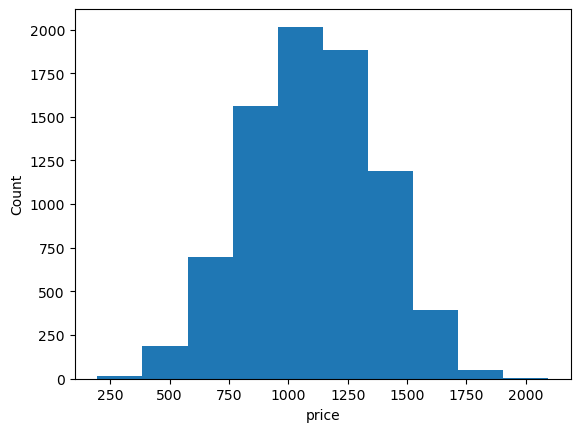

In [854]:
# Distribution of the target vriable
plt.hist(df['price'], bins=10)
plt.xlabel('price')
plt.ylabel('Count')
plt.show()

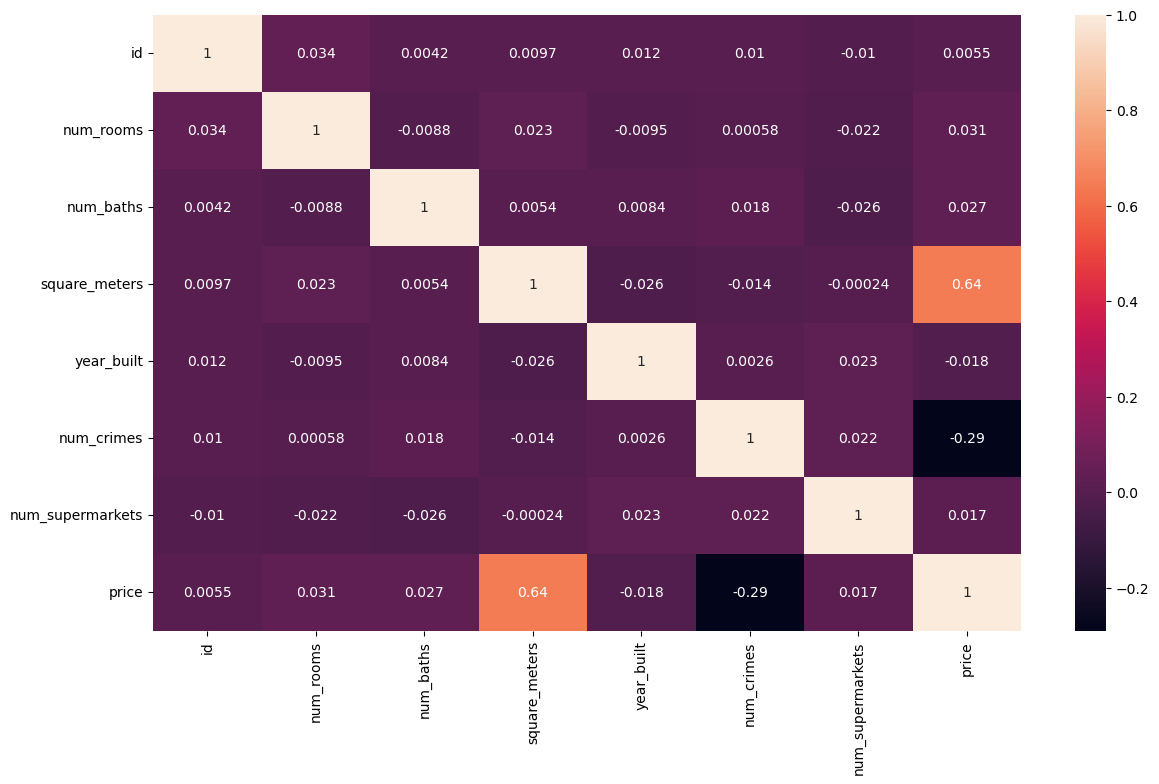

In [855]:
# Correlations among the variables 
df_for_heatmap = df.drop(columns=['door', 'orientation', 'neighborhood', 'is_furnished', 'has_pool', 'has_ac', 'accepts_pets'])
df_for_heatmap_corr = df_for_heatmap.corr()

# Plot correlations
fig, ax = plt.subplots(figsize=(14,8))
ax = sns.heatmap(df_for_heatmap_corr, annot = True)

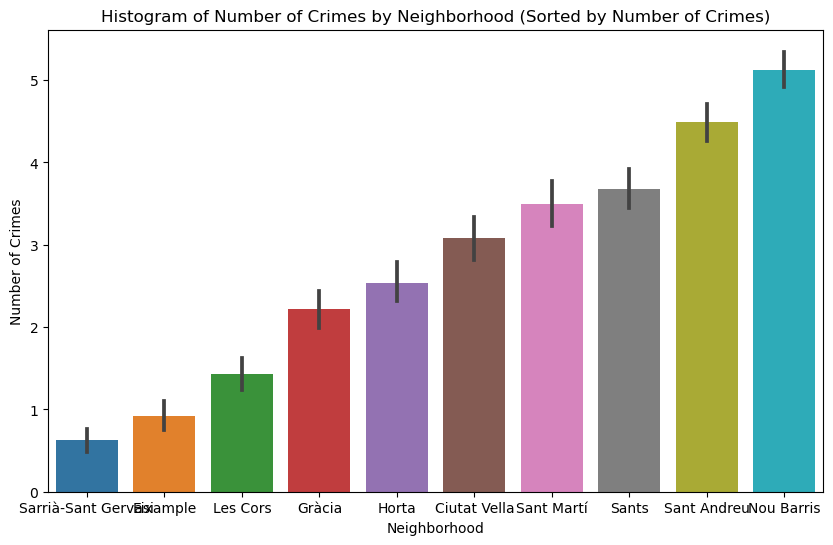

In [856]:
# Sort the neighborhoods by the number of crimes in descending order
sorted_neighborhoods = df.groupby('neighborhood')['num_crimes'].sum().sort_values(ascending=True).index

# Create a barplot (histogram) for neighborhoods and num_crimes, ordered by the number of crimes
plt.figure(figsize=(10, 6))
sns.barplot(x='neighborhood', y='num_crimes', data=df, order=sorted_neighborhoods)

plt.xlabel('Neighborhood')
plt.ylabel('Number of Crimes')
plt.title('Histogram of Number of Crimes by Neighborhood (Sorted by Number of Crimes)')
plt.show()

## Handling Missing Data and Categorical Variables

In [857]:
# Function to create table of missing values
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)

                # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [858]:
# Check the NAs
print(missing_values_table(df))
print(missing_values_table(df_test))

Your selected dataframe has 15 columns.
There are 12 columns that have missing values.
                  Missing Values  % of Total Values
num_supermarkets            6589               82.4
orientation                 2341               29.3
year_built                   170                2.1
has_ac                       169                2.1
is_furnished                 165                2.1
neighborhood                 165                2.1
num_baths                    160                2.0
num_crimes                   160                2.0
has_pool                     156                2.0
square_meters                155                1.9
accepts_pets                 155                1.9
door                         149                1.9
Your selected dataframe has 14 columns.
There are 13 columns that have missing values.
                  Missing Values  % of Total Values
num_supermarkets            1626               81.3
orientation                  523              

<Axes: >

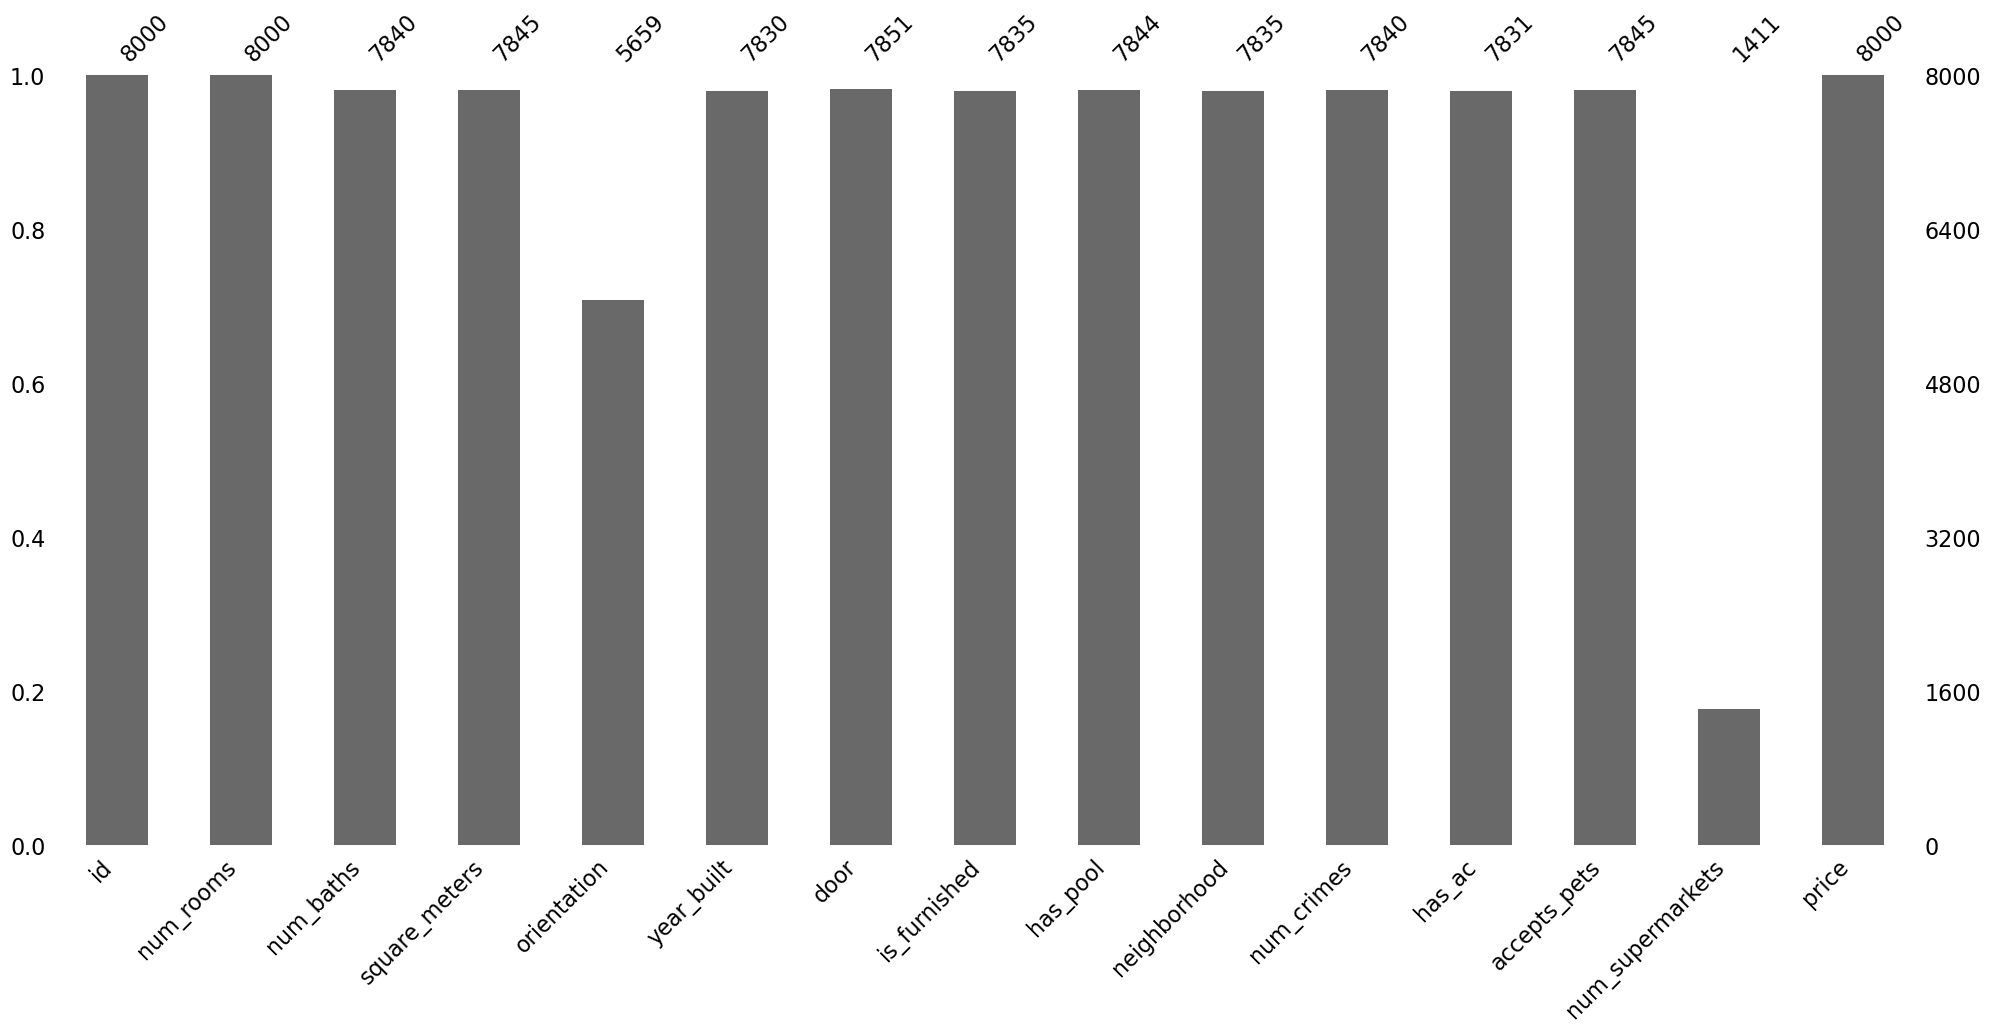

In [859]:
# NaNs distibution along the variables
msno.bar(df)

In [860]:
# Data-dense representation of the NaN distribution (didnt' work though)
#msno.matrix(df)

<Axes: >

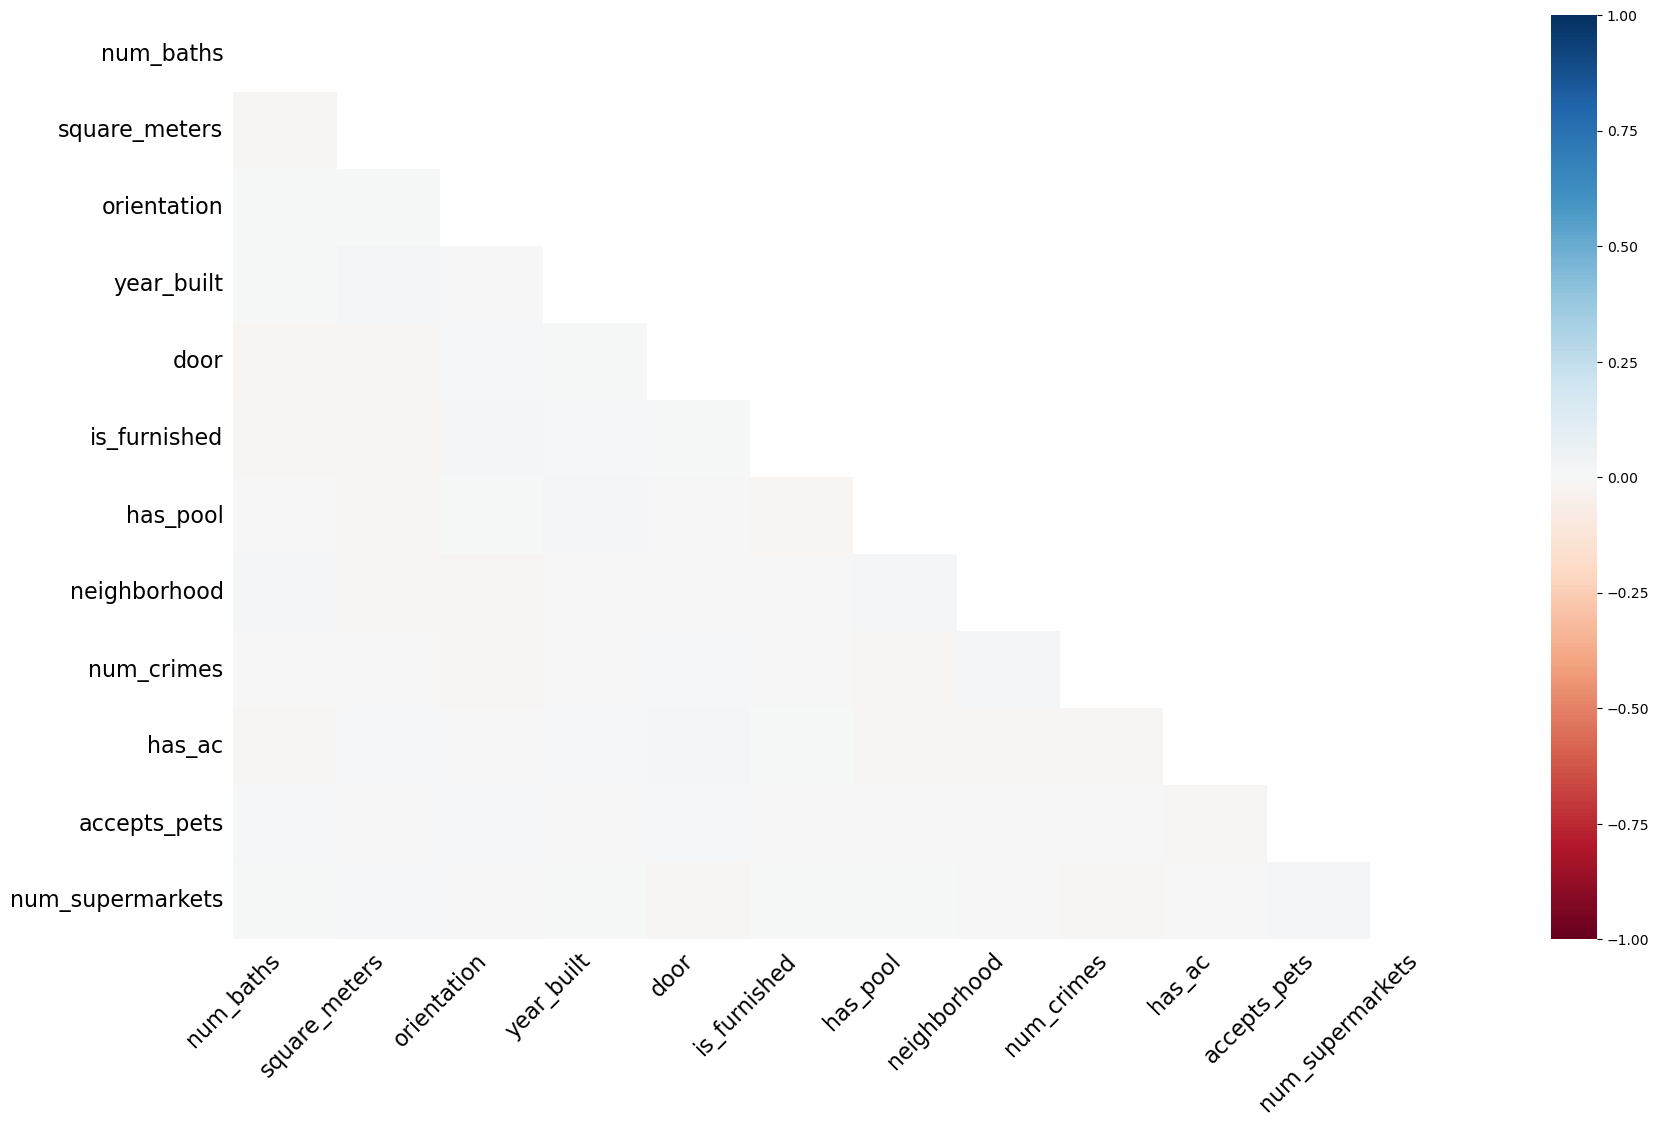

In [861]:
# Check, if there are correlations among NaNs
msno.heatmap(df)

In [862]:
# Dealing with NA:
# orientation - one hot encoding and KNN then
# num_baths, square_meters - KNN - doesn't really work well, probably because correlation is low, so i imputed mean by the group num_room
# year_built - mean bygroup neighbourhood
# door - 0 as constant
# is_furnished - KNN
# has_pool - KNN
# num_crimes, num_supermarkets - KNN didn't work well, so i imputed mean by the group neighbourhood first
# has_ac - KNN
# accepts_pets - KNN
# neighborhood - one hot encoding + ?

In [863]:
# Function to calculate mean for the groups
def mean_group(df, column_groupby, columns_to_impute):
    groupby_mean = df.groupby(column_groupby)[columns_to_impute].transform('mean')
    df[columns_to_impute] = df[columns_to_impute].fillna(groupby_mean)
    
    return df


In [864]:
# Call the function to impute means grouped by neighbourhood
df = mean_group(df, 'neighborhood', ['year_built', 'num_supermarkets', 'num_crimes'])
df_test = mean_group(df_test, 'neighborhood', ['year_built', 'num_supermarkets', 'num_crimes'])
print(df_test.isna().sum())

id                    0
num_rooms           191
num_baths            40
square_meters        43
orientation         523
year_built            0
door                 51
is_furnished         35
has_pool             44
neighborhood         35
num_crimes            0
has_ac               31
accepts_pets         45
num_supermarkets     32
dtype: int64


In [865]:
# Call the function to impute means grouped by num_rooms (means calculated on the besis of df_train data - not yet done)
df = mean_group(df, 'num_rooms', ['num_baths', 'square_meters'])
df_test = mean_group(df_test, 'num_rooms', ['num_baths', 'square_meters'])
print(df_test.isna().sum())

id                    0
num_rooms           191
num_baths             5
square_meters         6
orientation         523
year_built            0
door                 51
is_furnished         35
has_pool             44
neighborhood         35
num_crimes            0
has_ac               31
accepts_pets         45
num_supermarkets     32
dtype: int64


In [866]:
# What are the unique values in orientation
df['orientation'] = df['orientation'].replace('soxth', 'south')
df_test['orientation'] = df_test['orientation'].replace('soxth', 'south')
unique_values = df['orientation'].unique()
print(unique_values)
# What are the unique values in neighborhood
unique_values = df['neighborhood'].unique()
print(unique_values)

[nan 'west' 'east' 'north' 'south']
['Sant Martí' 'Sants' 'Eixample' 'Gràcia' nan 'Les Cors'
 'Sarrià-Sant Gervasi' 'Horta' 'Sant Andreu' 'Ciutat Vella' 'Nou Barris']


In [867]:
# Function to create dummies, do it in the part of dealing with NA to use these columns for KNN as the next step
def encode(df, columns_hot):
    encoded_df = pd.get_dummies(df, columns=columns_hot, dtype=float)
    return encoded_df

In [868]:
# Execute function for df and df_test
df = encode(df, ['orientation'])
df_test = encode(df_test, ['orientation'])
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 2000 non-null   int64  
 1   num_rooms          1809 non-null   float64
 2   num_baths          1995 non-null   float64
 3   square_meters      1994 non-null   float64
 4   year_built         2000 non-null   float64
 5   door               1949 non-null   object 
 6   is_furnished       1965 non-null   object 
 7   has_pool           1956 non-null   object 
 8   neighborhood       1965 non-null   object 
 9   num_crimes         2000 non-null   float64
 10  has_ac             1969 non-null   object 
 11  accepts_pets       1955 non-null   object 
 12  num_supermarkets   1968 non-null   float64
 13  orientation_east   2000 non-null   float64
 14  orientation_north  2000 non-null   float64
 15  orientation_south  2000 non-null   float64
 16  orientation_west   2000 

In [869]:
# Calculate the mean num_crimes for each neighborhood and replace 'neighborhood' with the mean values
df['neighborhood'] = df.groupby('neighborhood')['num_crimes'].transform('mean')
df_test['neighborhood'] = df_test.groupby('neighborhood')['num_crimes'].transform('mean')

# Rename the column to reflect that it now contains mean values
df.rename(columns={'neighborhood': 'mean_num_crimes'}, inplace=True)
df_test.rename(columns={'neighborhood': 'mean_num_crimes'}, inplace=True)
df_test.head()

,id,num_rooms,num_baths,square_meters,year_built,door,is_furnished,has_pool,mean_num_crimes,num_crimes,has_ac,accepts_pets,num_supermarkets,orientation_east,orientation_north,orientation_south,orientation_west
0,6253,NaN,1.0,152.0,2012.0,5º - 4a,True,True,1.558282,0.0,False,False,1.812500,0.0,0.0,0.0,0.0
1,4685,NaN,2.0,90.0,1957.0,10º - 1a,True,False,2.935000,2.0,False,True,3.000000,1.0,0.0,0.0,0.0
2,1732,NaN,2.0,86.0,1991.0,5º - 2a,False,False,0.891626,0.0,False,True,2.176471,0.0,0.0,0.0,0.0
3,4743,NaN,3.0,164.0,2002.0,8º - 4a,False,True,5.094059,7.0,False,False,1.925000,0.0,0.0,0.0,0.0
4,4522,NaN,1.0,99.0,1984.0,8º - 4a,True,True,4.447368,0.0,True,False,3.000000,0.0,0.0,0.0,0.0


In [870]:
# Calculate the correlation between 'mean_num_crimes' and 'num_crimes'
correlation = df_test['mean_num_crimes'].corr(df_test['num_crimes'])
print(correlation)

0.43699436617309967


In [871]:
# Impute missing values with a constant (e.g., 0)
df['door'].fillna(0, inplace=True)
df_test['door'].fillna(0, inplace=True)
print(df_test.isna().sum())

id                     0
num_rooms            191
num_baths              5
square_meters          6
year_built             0
door                   0
is_furnished          35
has_pool              44
mean_num_crimes       35
num_crimes             0
has_ac                31
accepts_pets          45
num_supermarkets      32
orientation_east       0
orientation_north      0
orientation_south      0
orientation_west       0
dtype: int64


In [872]:
# Create features in order to use these columns for KNN as the next step
# Split the 'door' column into 'floor' and 'apartment' columns
df[['floor', 'apartment']] = df['door'].str.split(' - ', expand=True)
df_test[['floor', 'apartment']] = df_test['door'].str.split(' - ', expand=True)

# Remove any non-numeric characters from the 'apartment' column
df['apartment'] = df['apartment'].str.extract('(\d+)')
df_test['apartment'] = df_test['apartment'].str.extract('(\d+)')

# Remove '^0' from the 'floor' column
df['floor'] = df['floor'].str.replace('º', '', regex=True)
df_test['floor'] = df_test['floor'].str.replace('º', '', regex=True)

# Drop the 'door' column
df.drop(columns=['door'], inplace=True)
df_test.drop(columns=['door'], inplace=True)

# Print the updated DataFrame
print(df_test.head())

     id  num_rooms  num_baths  square_meters  year_built is_furnished  \
0  6253        NaN        1.0          152.0      2012.0         True   
1  4685        NaN        2.0           90.0      1957.0         True   
2  1732        NaN        2.0           86.0      1991.0        False   
3  4743        NaN        3.0          164.0      2002.0        False   
4  4522        NaN        1.0           99.0      1984.0         True   

  has_pool  mean_num_crimes  num_crimes has_ac accepts_pets  num_supermarkets  \
0     True         1.558282         0.0  False        False          1.812500   
1    False         2.935000         2.0  False         True          3.000000   
2    False         0.891626         0.0  False         True          2.176471   
3     True         5.094059         7.0  False        False          1.925000   
4     True         4.447368         0.0   True        False          3.000000   

   orientation_east  orientation_north  orientation_south  orientation_wes

In [873]:
# Check unique values for the floor
unique_floor_values = df['floor'].unique()
print(unique_floor_values)

['3' '7' '1' '6' '5' '10' nan '2' '8' '4' '9']


In [874]:
# Check the NA left
#print(df.isna().sum())
print(df_test.isna().sum())


id                     0
num_rooms            191
num_baths              5
square_meters          6
year_built             0
is_furnished          35
has_pool              44
mean_num_crimes       35
num_crimes             0
has_ac                31
accepts_pets          45
num_supermarkets      32
orientation_east       0
orientation_north      0
orientation_south      0
orientation_west       0
floor                 51
apartment             51
dtype: int64


In [875]:
# Impute NAs left with KNN

# Specify the columns to impute
columns_to_impute = ['num_rooms', 'num_baths', 'year_built', 'square_meters', 'is_furnished', 'has_pool', 'num_crimes', 'has_ac', 'accepts_pets', 'num_supermarkets', 'floor', 'apartment', 'mean_num_crimes']

# Create a KNNImputer object with k=3 (or another suitable value)
imputer = KNNImputer(n_neighbors=3)

# Perform KNN imputation only on the specified columns for the training data
df[columns_to_impute] = imputer.fit_transform(df[columns_to_impute])

# Perform KNN imputation on the same columns for the test data (use the same imputer)
df_test[columns_to_impute] = imputer.transform(df_test[columns_to_impute])

In [876]:
# Check if data is clean
df_test.isna().sum()

id                   0
num_rooms            0
num_baths            0
square_meters        0
year_built           0
is_furnished         0
has_pool             0
mean_num_crimes      0
num_crimes           0
has_ac               0
accepts_pets         0
num_supermarkets     0
orientation_east     0
orientation_north    0
orientation_south    0
orientation_west     0
floor                0
apartment            0
dtype: int64

In [877]:
# Check if the shape didn't change
print(df.shape)
print(df_test.shape)

(8000, 19)
(2000, 18)


## Addressing Categorical Features and Outliers

In [878]:
# Look at unique values of square_meters - there are negative numbers
df.square_meters.unique()

array([ 107.4186747 ,  133.        ,  137.        ,  -41.        ,
         70.        ,   77.        ,  170.        ,  117.        ,
         59.        ,   52.        ,  101.        ,  115.        ,
        152.        ,  161.        ,  154.        ,   57.        ,
        134.        ,  167.        ,   62.        ,  163.        ,
        118.        ,   83.        ,  160.        ,   89.        ,
        108.2954071 ,  135.        ,  125.        ,   60.        ,
        149.        ,  138.        ,  128.        ,  162.        ,
        104.        ,  169.        ,  131.        ,  166.        ,
         88.        ,  105.        ,   73.        ,  158.        ,
        107.        ,  111.        ,   86.        ,   68.        ,
        164.        ,  121.        ,   64.        ,  156.        ,
        102.        ,   66.        ,  168.        ,   61.        ,
        143.        ,  109.        ,   54.        ,  119.        ,
        108.        ,   74.        ,   90.        ,  153.     

In [879]:
# We can see that some values match the amount of rooms and possible square meters (but not all of them actially - will work on those later). 
df[(df['square_meters'] < 0) & (df['num_rooms'] >= 0)]

,id,num_rooms,num_baths,square_meters,year_built,is_furnished,has_pool,mean_num_crimes,num_crimes,has_ac,accepts_pets,num_supermarkets,price,orientation_east,orientation_north,orientation_south,orientation_west,floor,apartment
3,6088,1.0,2.000000,-41.0,2002.0,0.0,1.000000,3.673267,5.0,0.0,0.0,2.045455,1290,0.0,0.0,0.0,0.0,6.0,1.0
126,5226,4.0,1.000000,-15.0,1984.0,1.0,0.666667,4.488462,2.0,0.0,1.0,1.921739,1093,0.0,0.0,0.0,1.0,6.0,2.0
129,1053,3.0,3.000000,-97.0,2000.0,1.0,1.000000,3.076628,0.0,0.0,1.0,2.007407,1352,1.0,0.0,0.0,0.0,1.0,3.0
156,3729,3.0,1.000000,-78.0,2009.0,0.0,0.000000,2.215190,6.0,0.0,1.0,1.875000,678,0.0,0.0,0.0,1.0,9.0,2.0
169,6815,1.0,3.000000,-36.0,1966.0,1.0,0.000000,0.628342,0.0,1.0,1.0,1.958678,982,0.0,0.0,0.0,0.0,2.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7665,7344,4.0,1.977296,-68.0,1957.0,0.0,0.333333,3.076628,8.0,0.0,0.0,1.000000,842,0.0,0.0,1.0,0.0,9.0,1.0
7688,6103,1.0,2.000000,-72.0,1976.0,1.0,0.000000,3.497333,2.0,0.0,0.0,2.000000,873,0.0,0.0,0.0,1.0,2.0,1.0
7833,3305,2.0,1.000000,-11.0,1993.0,0.0,0.000000,0.921438,0.0,0.0,1.0,1.971014,1343,0.0,0.0,0.0,1.0,9.0,3.0
7916,5277,1.0,1.000000,-73.0,2001.0,0.0,1.000000,0.628342,0.0,1.0,0.0,1.958678,1074,0.0,0.0,0.0,1.0,1.0,2.0


In [880]:
# Remove the minuses in the column square_meters
df['square_meters'] = df['square_meters'].abs()
df_test['square_meters'] = df_test['square_meters'].abs()

In [881]:
# Run a check
df[(df['square_meters'] < 0) & (df['num_rooms'] >= 0)]

,id,num_rooms,num_baths,square_meters,year_built,is_furnished,has_pool,mean_num_crimes,num_crimes,has_ac,accepts_pets,num_supermarkets,price,orientation_east,orientation_north,orientation_south,orientation_west,floor,apartment


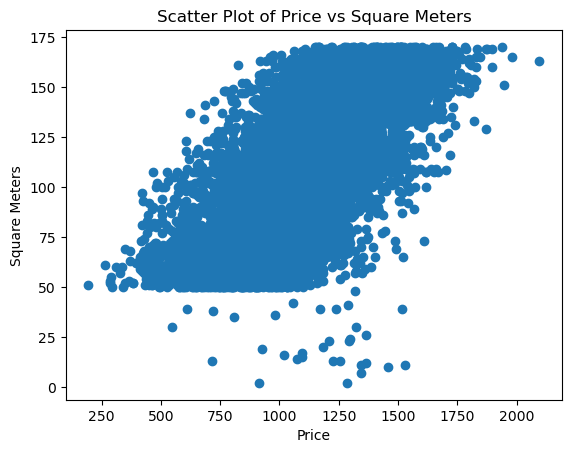

In [882]:
# Create a scatter plot to see, if there are strange values
plt.scatter(df['price'], df['square_meters'])
plt.xlabel('Price')
plt.ylabel('Square Meters')
plt.title('Scatter Plot of Price vs Square Meters')
plt.show()

In [883]:
# Number of strange values having viewd the box plot. 
count_small = len(df_test[df_test['square_meters'] < 49])
count = len(df_test['square_meters'])
print(count)
print(count_small)
print((count_small/count)*100)

2000
14
0.7000000000000001


In [884]:
# Winsorize nsuper small numbers in square_meters column
# Calculate the 0.7th percentile
seventh_tenths_percentile = df['square_meters'].quantile(0.007)
seventh_tenths_percentile_test = df_test['square_meters'].quantile(0.007)

# Sort the 'square_meters' column
sorted_square_meters = df['square_meters'].sort_values()
sorted_square_meters_test = df_test['square_meters'].sort_values()

# Identify the threshold value for windsorization
threshold_index = int(len(sorted_square_meters) * 0.007)
threshold_value = sorted_square_meters.iloc[threshold_index]
threshold_index_test = int(len(sorted_square_meters_test) * 0.007)
threshold_value_test = sorted_square_meters_test.iloc[threshold_index_test]

# Windsorize the 'square_meters' column
df['square_meters'] = df['square_meters'].apply(lambda x: threshold_value if x < threshold_value else x)
df_test['square_meters'] = df_test['square_meters'].apply(lambda x: threshold_value_test if x < threshold_value_test else x)

In [885]:
# Number of outliers having viewd the box plot. 
count_small = len(df_test[df_test['square_meters'] < 49])
print(count_small)

0


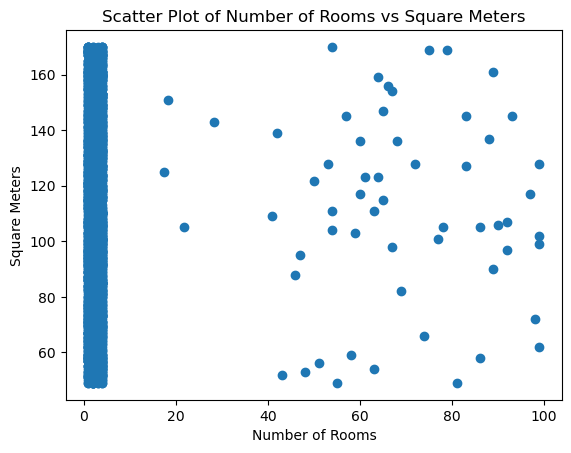

In [886]:
# Create a scatter plot to see, if there are strange values
plt.scatter(df_test['num_rooms'], df_test['square_meters'])
plt.xlabel('Number of Rooms')
plt.ylabel('Square Meters')
plt.title('Scatter Plot of Number of Rooms vs Square Meters')
plt.show()

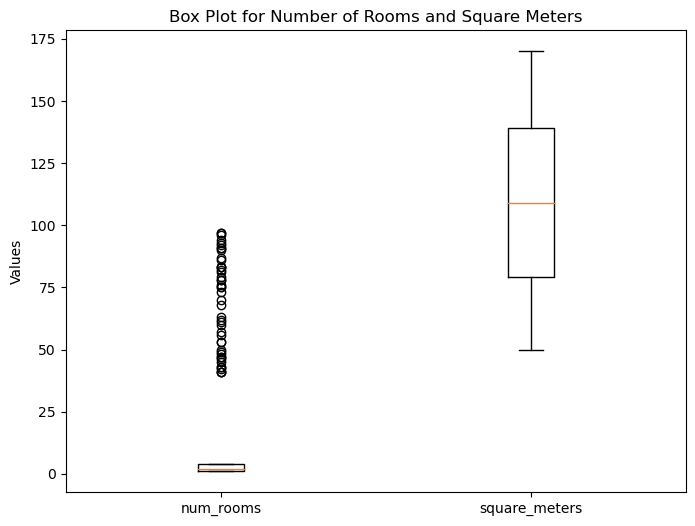

In [887]:
# Create a box plot for num_rooms and square_meters
plt.figure(figsize=(8, 6))  # Adjust the figure size if needed
plt.boxplot([df['num_rooms'], df['square_meters']], labels=['num_rooms', 'square_meters'])
plt.ylabel('Values')
plt.title('Box Plot for Number of Rooms and Square Meters')
plt.show()

In [888]:
# Number of outliers having viewd the box plot. 
count = len(df_test[df_test['num_rooms'] > 25])
count

55

In [889]:
# Winsorize na in the column num_rooms

# Calculate the 1st and 99th percentiles
first_percentile = df['num_rooms'].quantile(0.01)
ninety_ninth_percentile = df['num_rooms'].quantile(0.99)

# Windsorize the 'num_rooms' column
df['num_rooms'] = df['num_rooms'].apply(lambda x: first_percentile if x < first_percentile else (ninety_ninth_percentile if x > ninety_ninth_percentile else x))
df_test['num_rooms'] = df_test['num_rooms'].apply(lambda x: first_percentile if x < first_percentile else (ninety_ninth_percentile if x > ninety_ninth_percentile else x))




In [890]:
# Number of outliers having viewd the box plot. 
count = len(df_test[df_test['num_rooms'] > 25])
count

0

In [891]:
df_test.describe()

,id,num_rooms,num_baths,square_meters,year_built,is_furnished,has_pool,mean_num_crimes,num_crimes,has_ac,accepts_pets,num_supermarkets,orientation_east,orientation_north,orientation_south,orientation_west,floor,apartment
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.0000,2000.000000,2000.000000,2000.000000
mean,4952.472500,2.545000,2.007829,109.232745,1985.505349,0.497833,0.479500,2.682752,2.673496,0.503667,0.505833,1.987034,0.174000,0.184500,0.1950,0.185000,5.600667,2.455833
std,2884.100313,1.096671,0.805392,34.689178,20.548918,0.497446,0.496916,1.462243,3.362847,0.497772,0.496522,0.361537,0.379204,0.387988,0.3963,0.388395,2.880164,1.107548
min,1.000000,1.000000,1.000000,49.000000,1950.000000,0.000000,0.000000,0.367568,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.0000,0.000000,1.000000,1.000000
25%,2463.500000,2.000000,1.000000,80.000000,1969.000000,0.000000,0.000000,1.558282,0.000000,0.000000,0.000000,1.925000,0.000000,0.000000,0.0000,0.000000,3.000000,1.000000
50%,4950.500000,2.666667,2.000000,108.635104,1986.000000,0.333333,0.000000,2.935000,0.000000,0.666667,0.666667,1.948718,0.000000,0.000000,0.0000,0.000000,6.000000,2.000000
75%,7488.250000,3.666667,3.000000,138.250000,2003.000000,1.000000,1.000000,3.944751,5.000000,1.000000,1.000000,2.075472,0.000000,0.000000,0.0000,0.000000,8.000000,3.000000
max,9999.000000,4.000000,3.000000,170.000000,2021.000000,1.000000,1.000000,5.094059,10.000000,1.000000,1.000000,3.000000,1.000000,1.000000,1.0000,1.000000,10.000000,4.000000


In [892]:
def standardize(df, columns):
    for column in columns:
        df[column + '_standardized'] = (df[column] - df[column].mean()) / df[column].std()
    
    # Drop the original columns
    df.drop(columns=columns, inplace=True)
    
    return df

columns_to_standardize = ['num_rooms', 'num_baths', 'square_meters', 'year_built', 'num_crimes', 'num_supermarkets', 'mean_num_crimes']
df = standardize(df, columns_to_standardize)
df_test = standardize(df_test, columns_to_standardize)
df.head()

,id,is_furnished,has_pool,has_ac,accepts_pets,price,orientation_east,orientation_north,orientation_south,orientation_west,floor,apartment,num_rooms_standardized,num_baths_standardized,square_meters_standardized,year_built_standardized,num_crimes_standardized,num_supermarkets_standardized,mean_num_crimes_standardized
0,9255,0.0,0.0,1.0,1.0,1096,0.0,0.0,0.0,0.0,3.0,1.0,-1.332816,-1.223443,-0.052396,-1.439220,-0.234568,0.168208,0.500179
1,1562,0.0,0.0,0.0,0.0,1396,0.0,0.0,0.0,1.0,7.0,2.0,1.335929,-1.223443,0.682848,-1.242878,0.350427,0.061588,0.624945
2,1671,0.0,1.0,0.0,0.0,1263,0.0,0.0,0.0,0.0,1.0,1.0,-0.443234,1.252568,0.797814,0.720545,-0.819562,-0.023090,-1.326550
3,6088,0.0,1.0,0.0,0.0,1290,0.0,0.0,0.0,0.0,6.0,1.0,-1.332816,0.014563,-1.702692,0.818716,0.642924,0.194379,0.624945
4,6670,1.0,0.0,0.0,1.0,962,0.0,0.0,0.0,0.0,5.0,1.0,-0.443234,-1.223443,-1.127863,-0.310252,-0.819562,2.982986,-0.409069


In [893]:
df.describe()

,id,is_furnished,has_pool,has_ac,accepts_pets,price,orientation_east,orientation_north,orientation_south,orientation_west,floor,apartment,num_rooms_standardized,num_baths_standardized,square_meters_standardized,year_built_standardized,num_crimes_standardized,num_supermarkets_standardized,mean_num_crimes_standardized
count,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8.000000e+03,8.000000e+03,8.000000e+03,8.000000e+03,8.000000e+03,8.000000e+03,8.000000e+03
mean,5012.506875,0.481667,0.504208,0.503958,0.508083,1099.616250,0.175125,0.177250,0.172375,0.182625,5.584750,2.506667,-5.195844e-17,2.140510e-16,8.038015e-17,8.512302e-15,2.398082e-17,-1.261213e-16,3.532730e-16
std,2887.649416,0.496012,0.496697,0.496643,0.496844,271.686617,0.380098,0.381904,0.377730,0.386383,2.827938,1.116629,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,2.000000,0.000000,0.000000,0.000000,0.000000,195.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,-1.332816e+00,-1.223443e+00,-1.702692e+00,-1.733734e+00,-8.195621e-01,-2.859810e+00,-1.534403e+00
25%,2512.750000,0.000000,0.000000,0.000000,0.000000,905.750000,0.000000,0.000000,0.000000,0.000000,3.000000,2.000000,-1.332816e+00,-1.223443e+00,-8.691899e-01,-8.501932e-01,-8.195621e-01,-1.102591e-01,-9.667711e-01
50%,5014.500000,0.000000,0.666667,0.666667,1.000000,1104.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2.666667,-4.432340e-01,1.456264e-02,-1.154466e-02,-1.573846e-02,-5.270649e-01,-2.309031e-02,2.018309e-01
75%,7505.250000,1.000000,1.000000,1.000000,1.000000,1295.000000,0.000000,0.000000,0.000000,0.000000,8.000000,4.000000,1.335929e+00,1.252568e+00,8.552967e-01,8.678019e-01,6.429238e-01,1.682083e-01,6.249451e-01
max,10000.000000,1.000000,1.000000,1.000000,1.000000,2095.000000,1.000000,1.000000,1.000000,1.000000,10.000000,4.000000,1.335929e+00,1.252568e+00,1.746281e+00,1.751342e+00,2.105410e+00,2.982986e+00,1.650281e+00


In [894]:
print(df_test.shape)
print(df.shape)

(2000, 18)
(8000, 19)


In [895]:
df_test.isna().sum()

id                               0
is_furnished                     0
has_pool                         0
has_ac                           0
accepts_pets                     0
orientation_east                 0
orientation_north                0
orientation_south                0
orientation_west                 0
floor                            0
apartment                        0
num_rooms_standardized           0
num_baths_standardized           0
square_meters_standardized       0
year_built_standardized          0
num_crimes_standardized          0
num_supermarkets_standardized    0
mean_num_crimes_standardized     0
dtype: int64

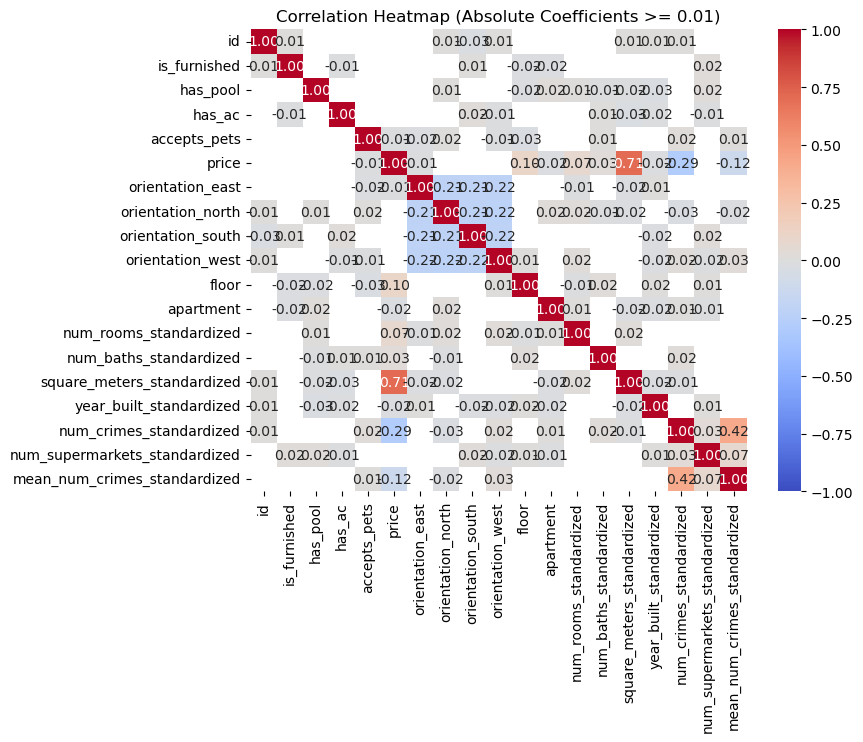

In [896]:
# Calculate the correlation matrix
correlation_matrix = df.corr()

# Create a mask to hide coefficients below 0.01
mask = correlation_matrix.abs() < 0.01
correlation_matrix = correlation_matrix.mask(mask)

# Create a heatmap with coefficients rounded to two decimal places
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt=".2f")
plt.title('Correlation Heatmap (Absolute Coefficients >= 0.01)')
plt.show()

In [897]:
# Calculate the correlations of 'price' with all other columns
correlations = df.corr()['price']

print(correlations)

id                               0.005516
is_furnished                     0.006506
has_pool                         0.000824
has_ac                          -0.007702
accepts_pets                    -0.010043
price                            1.000000
orientation_east                -0.010132
orientation_north               -0.005406
orientation_south                0.004248
orientation_west                -0.001838
floor                            0.102718
apartment                       -0.018232
num_rooms_standardized           0.071772
num_baths_standardized           0.026672
square_meters_standardized       0.706423
year_built_standardized         -0.017614
num_crimes_standardized         -0.288184
num_supermarkets_standardized   -0.000678
mean_num_crimes_standardized    -0.123132
Name: price, dtype: float64


In [898]:
# Remove features with multilollinearity
df = df.drop('mean_num_crimes_standardized', axis=1)
df_test = df_test.drop('mean_num_crimes_standardized', axis=1)

In [899]:
# Function to split data
def splitdata(df, target_column):
    X = df.drop(target_column, axis=1)
    y = df[target_column]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    return X_train, X_test, y_train, y_test

In [900]:
# Call the splitdata function
X_train, X_test, y_train, y_test = splitdata(df, 'price')

# Now you can print the values
print(f'X_train: {X_train}')
print(f'X_test: {X_test}')
print(f'y_train: {y_train}')
print(f'y_test: {y_test}')

X_train:         id  is_furnished  has_pool  has_ac  accepts_pets  orientation_east  \
6760  2984           1.0  0.666667     0.0           1.0               1.0   
4623  3489           0.0  1.000000     1.0           1.0               0.0   
7841  5576           1.0  1.000000     0.0           1.0               0.0   
3704  4938           1.0  0.000000     1.0           0.0               0.0   
981   9357           0.0  1.000000     1.0           1.0               0.0   
...    ...           ...       ...     ...           ...               ...   
5226  8872           0.0  0.000000     1.0           0.0               0.0   
5390  9827           1.0  1.000000     0.0           0.0               0.0   
860   5269           1.0  1.000000     0.0           0.0               0.0   
7603  9667           0.0  0.000000     1.0           1.0               0.0   
7270  6091           0.0  0.000000     1.0           0.0               0.0   

      orientation_north  orientation_south  orientatio

In [901]:
# def model(X_train, X_test, y_train, y_test):
#     # Initialize and train the model
#     model = LinearRegression()
#     model.fit(X_train, y_train)

#     # Make predictions
#     train_predictions = model.predict(X_train)
#     test_predictions = model.predict(X_test)

#     # Compute metrics
#     train_mse = mean_squared_error(y_train, train_predictions)
#     test_mse = mean_squared_error(y_test, test_predictions)

#     train_r2 = r2_score(y_train, train_predictions)
#     test_r2 = r2_score(y_test, test_predictions)

#     print("Train MSE:", train_mse)
#     print("Test MSE:", test_mse)
#     print("Train R^2:", train_r2)
#     print("Test R^2:", test_r2)

#     # Return the results or any other data you need
#     return test_predictions

In [902]:
# # Execute training and metrics calculations
# X_train = X_train
# X_test = X_test
# y_train = y_train
# y_test = y_test
# result = model(X_train, X_test, y_train, y_test)
# print(result)

In [903]:
# Define the features and target
X_train = X_train
X_test = X_test
y_test = y_test
y_train = y_train

# Train the model
# For Logistic Regression:
model = LinearRegression()

model.fit(X_train, y_train)

# Make predictions
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

# Compute metrics
train_mse = mean_squared_error(y_train, train_predictions)
test_mse = mean_squared_error(y_test, test_predictions)

train_r2 = r2_score(y_train, train_predictions)
test_r2 = r2_score(y_test, test_predictions)

print("Train MSE:", train_mse)
print("Test MSE:", test_mse)
print("Train R^2:", train_r2)
print("Test R^2:", test_r2)

Train MSE: 29616.646099853973
Test MSE: 30880.71506974617
Train R^2: 0.5992247108601769
Test R^2: 0.5802988261733866


In [904]:
test_predictions = model.predict(df_test)

In [905]:
test_prediction_submit = pd.DataFrame({"id": df_test["id"],  "price": test_predictions })
test_prediction_submit.to_csv("test_submit.csv", index = False)